# Ring statistics code
Firstly it is important to have a clear definition of a ring. This code is built for SiO2. And, a ring is defined as follows:
- A ring is the shortest path starting from an atom Si_1, and ending with the same Si_1 atom made up by unique atoms (i.e no duplicates). 
- The vertices can only be Si atoms
- The path is only valid when made up by Si-O bonds. I.e. so Si_1-O_1-Si_2-O_2-Si_1 is a valid path but Si_1-O_1-Si_2-Si_1 is not. 
- The ring size is defined by how many Si atoms are present, except for the final one. I.e. the ring aforementioned would have a size of 2. 

In [1]:
# Import all necessary modules here
import ase
from ase.io import read,write
from ase import Atoms
import ase.neighborlist as nb
from ase.geometry.analysis import Analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, os.path
import fnmatch
import csv 
from collections import OrderedDict
from collections import Counter
#import multiprocessing
#from scipy import sparse

# Reading and assigning the data

In [2]:
# Define the path where the file is located
path = r' '

In [3]:
sio2 = [] # This will contain all the data from the various files
n = len(fnmatch.filter(os.listdir(path), '*.md')) # Setting the number of files 
#The following is to read the data
for name in fnmatch.filter(os.listdir(path), '*.md'): # Change the '*.md' as needed
    print (name) #Prints the name of the file
    sio2.append(read(path+name, index=':')[25002::100]) #Opens and reads the data and appends it to sio2
# The following is to check the number of frames in the dataset. 
for i in range(n):
    print("There are", len(sio2[i]), "frames in the system.")

19_01.md
There are 50 frames in the system.


# Periodic boundary

In [4]:
# Applying the periodic boundary
a, b, c = 8.77, 8.77, 20.48 # Simulations box size
for i in range(n):
    print (i)
    for j in range(len(sio2[i])):
        sio2[i][j].set_cell([(a, 0, 0), (0, b, 0), (0, 0, c)])
        sio2[i][j].set_pbc((True, True, True))
        sio2[i][j].get_positions()

0


# Ring stat functions
The code can be rewritten to be more efficient and elegant, however, this saves computational power as it does not need to iterate through every single atom to find the shortest path, as the path size is restricted. 

Furthermore, as you read the code you will see the choice of not using append, this is because a list created with .append() will keep the old information even if the starting path is changed, this can lead to errors so that is why the list is created "manually".

In [5]:
def ring_stat(i, j, atom, end):
    '''
    Looks for specific sizes of rings, with a maximum of 9. 
    
    Parameters
    -----------
    i: list of integers
        Atoms from 0 to 89.
    j: list of integers
        Atoms bonded to i, ie. i[0] is bonded to j[0].
    atom: integer
        Atom from where to start the path search.
    end: integer
        Atom at which the path must end, built-in redundancy in case atom is overwritten by mistake
    
    Returns:
    -----------
    path: list
        It contains the closed path, ie. . 
    '''
    initial_00 = atom # Saves the atom as the starting atom.
    indices_00 = j[np.where(i == atom)] # Makes a list of the atoms bonded to the starting atom.
    # Loop to iterate through each of the atoms bonnded to the initial one. 
    for index_00 in indices_00:
        initial_01 = index_00 # Saves the new atom 
        indices_01 = j[np.where(i == index_00)] # Gets the atoms bonded to this new atom
        for index_01 in indices_01: # Iterates through all the possible bonded atoms
            if index_01 != initial_00: # If the original atoms is present, then it is ignored, only new atoms will be considered
                var = [index_00, index_01]  # This saves the atoms of the current path
                if loop(i, j, index_01, var) is not None: # This avoids a recurring issue where the atoms are already part of the initial path, and hence the function returns None
                    index_02, index_03 = loop(i, j, index_01, var)
                    if index_03 == end: # If the index_03 is the same as the original atom, then it creates the path and returns it
                        path = [end, index_00, index_01, index_02, index_03]
                        return path
                    else: # If not a it goes on
                        var = [index_00, index_01, index_02]
                        if loop(i, j, index_03, var) is not None: 
                            index_04, index_05 = loop(i, j, index_03, var)
                            if index_05 == end:
                                path = [end, index_00, index_01, index_02, index_03, index_04, index_05]
                                return path
                            else:
                                if index_05 != index_03:
                                    var = [index_00, index_01, index_02, index_03, index_04]
                                    if loop(i, j, index_05, var) is not None:
                                        index_06, index_07 = loop(i, j, index_05, var)
                                        if index_07 == end:
                                            path = [end, index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07]
                                            return path
                                        else:
                                            if index_07 != index_05:
                                                var = [index_00, index_01, index_02, index_03, index_04, index_05, index_06]
                                                if loop(i, j, index_07, var) is not None:
                                                    index_08, index_09 = loop(i, j, index_07, var)
                                                    if index_09 == end:
                                                        path = [end, index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07]
                                                        path = path + [index_08, index_09]
                                                        return path
                                                    else:
                                                        if index_09 != index_07:
                                                            var = [index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07, index_08]
                                                            if loop(i, j, index_09, var) is not None:
                                                                index_10, index_11 = loop(i, j, index_09, var)
                                                                if index_11 == end:
                                                                    path = [end, index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07]
                                                                    path = path + [index_08, index_09, index_10, index_11]
                                                                    return path
                                                                else:
                                                                    if index_11 != index_09:
                                                                        var = [index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07, index_08, index_09, index_10]
                                                                        if loop(i, j, index_11, var) is not None:
                                                                            index_12, index_13 = loop(i, j, index_11, var)
                                                                            if index_13 == end:
                                                                                path = [end, index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07]
                                                                                path = path + [index_08, index_09, index_10, index_11, index_12, index_13]
                                                                                return path
                                                                            else:
                                                                                if index_13 != index_11:
                                                                                    var = [index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07, index_08, index_09, index_10, index_11, index_12]
                                                                                    if loop(i, j, index_13, var) is not None:
                                                                                        index_14, index_15 = loop(i, j, index_13, var)
                                                                                        if index_15 == end:
                                                                                            path = [end, index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07]
                                                                                            path = path + [index_08, index_09, index_10, index_11, index_12, index_13, index_14, index_15]
                                                                                            return path
                                                                                        else:
                                                                                            if index_15 != index_13:
                                                                                                var = [index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07, index_08, index_09, index_10, index_11, index_12, index_13, index_14]
                                                                                                if loop(i, j, index_15, var) is not None:
                                                                                                    index_16, index_17 = loop(i, j, index_15, var)
                                                                                                    if index_17 == end:
                                                                                                        path = [end, index_00, index_01, index_02, index_03, index_04, index_05, index_06, index_07]
                                                                                                        path = path + [index_08, index_09, index_10, index_11, index_12, index_13, index_14, index_15]
                                                                                                        path = path + [index_16, index_17]
                                                                                                        return path



def loop(i, j, atom, var):
    '''
    Used to reduce the lenght of the orginal function
    
    Parameters
    -----------
    i: list of integers
        Atoms from 0 to 89.
    j: list of integers
        Atoms bonded to i, ie. i[0] is bonded to j[0].
    atom: integer
        Atom from where to start the path search.
    end: integer
        Atom at which the path must end, built-in redundancy in case atom is overwritten by mistake
    var: list of integers
        This is the current path
    Returns:
    -----------
    index_00: integer
        It contains the penultimate atom in the path.
    index_01: integer
        It is the final atom in the path. 
    '''
    initial_00 = atom
    indices_00 = j[np.where(i==atom)]
    for index_00 in indices_00:
        if index_00 not in var:
            initial_01 = index_00
            indices_01 = j[np.where(i==index_00)]
            for index_01 in indices_01:
                if index_01 not in var:
                    return index_00, index_01

            

In [6]:
keys = [] # List, it will contain the information of what size ring are present in each calculation
h = [] # List, it will contain the frequency of rings sizes present in each calculation
averages = [] # List, it will contain the average ring size of each calculation
abs_rings = [] # List, used to store the rings in case the overall average is needed
for l in range(len(sio2)):
    print(l)
    frame_rings = []
    # The following is to check if the code is running, for very large files.
    for k in range(len(sio2[l])):
        if k%10 ==0:
            print(l,k)
        rings = [] # It will contain the ring count
        var = [] # This is a dummy variable to temporarily store the ring_stat function results
        ana = Analysis(sio2[l][k]) # Look at https://wiki.fysik.dtu.dk/ase/ase/geometry.html#analysis-tools
        i, j = nb.neighbor_list('ij', sio2[l][k], {('Si', 'O'): 1.8}) # https://wiki.fysik.dtu.dk/ase/ase/neighborlist.html#ase.neighborlist.neighbor_list
        # The following iterates through all the Si atom, they start from index 60 to 89. 
        for m in range(60, 90):
            var.append(ring_stat(i, j, m, m))
            #The following deletes any empty list
            if var[-1] is None:
                del var[-1]
        var2 = [] # Dummy variable #2, it is used in combination with var to get rid of any duplicate paths
        # The following sorts the path so that duplicate initial atom can be removed. 
        # In indsight it could have beena avoided by not adding the initial atom at the end, but it was needed to confirm the validity of the path
        for m in range(len(var)):
            var[m] = list(set(var[m]))
            var[m].sort()
        # The following gets rid of any duplicate paths
        for i in var:
            if i not in var2:
                var2.append(i)
                rings.append(len(i)/2) # Rings will contain the size of the ring, a ring of size x has 2x atoms, hence it is being divided by 2. 
        rings.sort() # Sorts the rings 
        my_dict = {i:rings.count(i) for i in rings} #Creates a dictionary to keep track of how many rings of size x are present as {x:n}
        frame_rings.append(my_dict) # Frame rings will contain the value for the specific frame.
        #print(frame_rings)
    # The following is used to create a single dictionary with the information from every single frame
    c = Counter()
    for d in frame_rings:
        c.update(d)
    calc_rings = dict(c)
    arr = [] # Another dummy variables used for storing data
    abs_rings.append(calc_rings)
    for key in calc_rings: # This totalizes the number of rings of size x.
        dummy = np.full(calc_rings[key], key)
        arr.append(np.bincount(dummy.tolist()))
    hist = [] # Variable to contain the data for the histogram
    for a in arr:
        hist.append(a[-1])
    key = list(calc_rings.keys()) # Creates a list of the varies rings sizes in the calculation
    # The following is used to calculate the average of the calculation
    x = 0
    for i in range(len(hist)):
        x += key[i]*hist[i]
    print (x) 
    avg = x/np.sum(hist)
    hist2 = hist/np.sum(hist)
    print (hist)
    print('average ring size = ', avg)
    avg = round(avg, 2)
    keys.append(key) # Saves the labels of the current calculation. 
    h.append(hist2) # Save the information of the frequency of the rings of the calculation
    averages.append(avg) # Saves the average of the calculation
# The following are prints to check for errors
# print(keys)
# print(h)
# print(averages)

0
0 0
0 10
0 20
0 30
0 40
767.0
[58, 106, 40, 6, 23, 2, 1]
average ring size =  3.25


# Average of all the calculations. 
- If multiple calculations are being analysed, the following will make an average of all the calculations. 
- If a single calculation is being used then leave it commented.

In [7]:
# # Average of all the calculations
# for d in abs_rings:
#     c.update(d)
# rings = dict(c)
# print ("rings", rings)
# key = list(rings.keys())
# arr = []
# for a in rings:
#     dummy = np.full(rings[a], a)
#     arr.append(np.bincount(dummy.tolist()))
# hist = []
# for a in arr:
#     hist.append(a[-1])
# x = 0
# for i in range(len(hist)):
#     x += key[i]*hist[i]
# avg = x/np.sum(hist)
# hist = hist/np.sum(hist)
# print('average ring size = ', avg)
# avg = round(avg, 2)
# keys.append(key)
# h.append(hist)
# averages.append(avg)
# print (len(key))
# print (key)
# print(keys[-1])
# print(len(keys))

# Errors on the average
This works only on a single calculation, hence if it is a single calculation uncomment it, otherwise, wait for the update. 

In [9]:
sumSquare = 0
for i in range(len(h[0])):
    sumSquare += (keys[0][i]*h[0][i]-averages[0])**2
standDev = np.sqrt(h)/np.sqrt(len(hist))
print(standDev)
print(h)
pStandDev = np.sqrt(sumSquare/(len(h[0])-1))
error = pStandDev/np.sqrt(len(h[0]))
print (error)

[[0.18737385 0.25330742 0.15560551 0.06026576 0.11799372 0.03479445
  0.02460339]]
[array([0.24576271, 0.44915254, 0.16949153, 0.02542373, 0.09745763,
       0.00847458, 0.00423729])]
1.1505150444527321


# Saving the data

In [10]:
# # open file for writing, "w" is writing
# w = csv.writer(open("19_ring.csv", "w"))
# # loop over dictionary keys and values
# for n in range(len(keys[0])):
#     # write every key and value to file
#     w.writerow([keys[0][n], h[0][n]])

# Plotting the data
There are two plotting systems.
- The first one is for a single calculation,
- The second one is for multiple calculations.
Comment/uncomment whichever one is needed. 

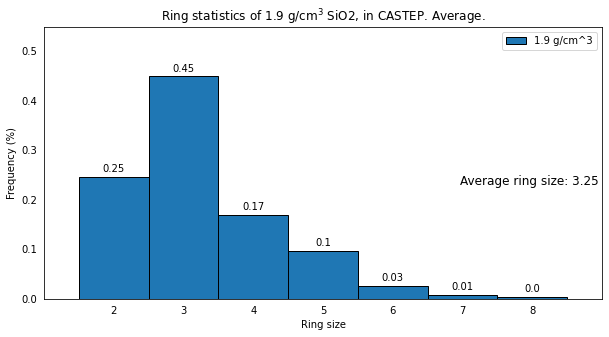

In [11]:
densities = 1.9 # density of the system
n = len(fnmatch.filter(os.listdir(path), '*.md')) # number of calculation of a specific density
# Plotting the results, change 1 to the number of calculations n, or if also including the full average n+1
fig, ax = plt.subplots(1, figsize=(10, 5)) # 
#Defining the labels and part of the title
x_label = "Ring size"
y_label = "Frequency (%)"
# if multiple calculations are being analysed at once, change the range from n to n+1 to include the average
# graph of all the calculations
for i in range(n):
    x_values = keys[i] # defines the x values
    width = 1 # The width of the bars
    y = h[i] # Defines the y values
    # Modify the title as needed
    title = "Ring statistics of " + str(densities) + " g/cm$^3$ SiO2, in CASTEP. Average."
    # Plotting the data
    bars = ax.bar(x_values, y, align='center', width=width,
               label= str(densities) + " g/cm^3", edgecolor = 'black')
    #Setting the labels
    ax.set(xlabel=x_label, ylabel=y_label,  title=title)
    #Creating the legend
    ax.legend()
    # Setting the axis limits for better visulization of the data
    ax.set_xlim(np.min(x_values)-1, np.max(x_values)+1)
    ax.set_ylim([0, np.max(h[i])+0.1])
    plt.xticks(x_values)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    # Labelling each bar with its y value rounded to 2 d.p. 
    for bar in bars:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.01,
          round(bar.get_height(), 2),
          horizontalalignment='center',
          color="black",
      )
    # Writing the average in the plot 
    avg = averages[i]
    text = f'Average ring size: {avg} \n'
    ax.text(9, 0.2, text, 
            horizontalalignment='right', fontsize=12)

In [12]:
# densities = 2.0 #  density of the system
# n = len(fnmatch.filter(os.listdir(path), '*.md'))
# # Plotting the results
# fig, ax = plt.subplots(n+1, figsize=(15, 45))
# x_label = "Ring size"
# y_label = "Frequency (%)"
# names = ["#01", "#02", "#03", "#04", "#05", "#06", '#07', "Average"] # Names of the different graphs.
# for i in range(n+1):
#     x_values = keys[i]
#     width = 1
#     y = h[i]
#     title = "Ring statistics of" + str(densities) + " g/cm^3 SiO2, in CASTEP. " + names[i] + "."
#     bars = ax[i].bar(x_values, y, align='center', width=width,
#                label= str(densities) + " g/cm^3", edgecolor = 'black')
#     ax[i].set(xlabel=x_label, ylabel=y_label,  title=title)
#     ax[i].legend()
#     ax[i].set_xlim(np.min(x_values)-1, np.max(x_values)+1)
#     ax[i].set_ylim([0, np.max(h[i])+0.1])
#     plt.xticks(x_values)
#     ax[i].tick_params(bottom=False, left=False)
#     ax[i].set_axisbelow(True)

#     for bar in bars:
#       ax[i].text(
#           bar.get_x() + bar.get_width() / 2,
#           bar.get_height() + 0.01,
#           round(bar.get_height(), 2),
#           horizontalalignment='center',
#           color="black",
#       )
#     # Writing the results in the plot 
#     avg = averages[i]
#     text = f'Average ring size: {avg} \n'
#     ax[i].text(7, 0.2, text, 
#             horizontalalignment='right', fontsize=12)